In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as sc
import cv2
import math

In [2]:
save_dir = 'C:/Users/lunam/Documents/1steMaster\Stage/Images_Report/Counting_Lesions/'

In [3]:
# different parameters that can be tuned
kernsize_closing = 2
closing_iterations = 1
minAreaLesion = 1
maxAreaLesion = 1000

OpticDisk_FilterSize = 9 # should be an odd value
OpticDisk_GapSize = 1 # should be an odd value
# OpticDisk_FilterSize = 25 # should be an odd value
# OpticDisk_GapSize = 3 # should be an odd value

In [4]:
# visualizing the images
def PlotImage(image_array, database = '', image_name = '', save = False, savepath = ''):
    '''Visualize (and save if desired) an image represented by a numpy array'''
    
    plt.figure()
    plt.title(database+': '+image_name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow(image_array, cmap=plt.cm.Greys_r)
    
    if save == True:
        plt.savefig(savepath+database+'_'+image_name+'.png')    
    return 

The functions below can be used to count the amount of lesions indicated on an annotation image (= a binary image that shows the lesions in white on a black background).

In [5]:
def Closing(image, kernsize, itera, plot = False):
    '''
    This function performs morphological closing on an image
    The kernel size that is used for closing and the number of iterations of the closing
    operation that are performed can be indicated
    '''
    closed_image = sc.morphology.binary_closing(image, structure=np.ones((kernsize,kernsize)), iterations=itera)
    
    if plot == True:
        PlotImage(closed_image, database = 'IDRiD Hemorrhages', image_name = 'Closed annotation', save = True, savepath = save_dir)
    return closed_image

In [6]:
def FindContours(image):
    '''
    This function can be used to find the contours around lesions
    the image has to be a binary image showing the lesions in white and the background in black
    the function returns a list with indices indicating the position of all contours
    '''
    contours, _= cv2.findContours(np.uint8(image), mode = cv2.RETR_LIST, method = cv2.CHAIN_APPROX_NONE)
    return contours   

In [7]:
def ShowContours(image, ContourList, title = ''):
    '''
    This function shows a binary image indicating the contours in white on a black background with the same
    size as the original image
    '''
    # black background
    contour_image = np.zeros(image.shape)
    
    # go over all contours and indicate them on the black background
    for contour_number in range(len(ContourList)):
        contour_indices = ContourList[contour_number]
        for index_number in range(len(contour_indices)):
            index = contour_indices[index_number][0]
            contour_image[index[1], index[0]] = 1
    
    # show the contours on an image
    PlotImage(contour_image, database = 'IDRiD Hemorrhages', image_name = title, save = True, savepath = save_dir)

In [8]:
def SelectAndCountContours(ContourList, minArea, maxArea):
    '''
    This function counts the amount of lesions based on the defined countours
    Based on the region enclosed by every contour it is defined whether the contour
    really indicates a lesion or not. The area enclosed by a contour should be inbetween boundaries.    
    '''
    
    # make a list of the contours that fall within the right boundaries
    real_contours = [] 
    for contour in ContourList: 
        if minArea < cv2.contourArea(contour) < maxArea: 
            real_contours.append(contour)
    
    # number of lesions equals the amount of 'real' contours
    n_lesions = len(real_contours)
    
    return n_lesions, real_contours

In [9]:
def CountLesions(Annotation, KernSizeClosing, IteratClosing, MinLesionArea, MaxLesionArea, Show = False):
    '''
    This function combines the above functions to count the lesions on a
    binary annotation file. The annotations file should have the lesions indicated in white on a black background
    '''
    # visualize the original annotation if needed
    if Show == True:
        PlotImage(Annotation, database = 'IDRiD Hemorrhages', image_name = 'Original annotation', save = True, savepath = save_dir)
    
    # perform closing on the image
    closed_image = Closing(Annotation, kernsize = KernSizeClosing, itera = IteratClosing, plot = Show)
    
    # define the list of contours
    contour_list = FindContours(closed_image)
    
    # define the 'real' contours and count them
    number_lesions, actual_contours = SelectAndCountContours(contour_list, minArea = MinLesionArea, maxArea = MaxLesionArea)
    
    # visualize the contours and real controus if needed
    if Show == True:
        ShowContours(Annotation, contour_list,  title = 'All contours')
        ShowContours(Annotation, actual_contours,  title = 'Selected contours')
        
    return number_lesions      

The functions below are used to find the center of the optic disk on a fundus image. This center is then used to divide the fundus image into four quadrants.

In [10]:
def DefineFilter(filter_size, gap_size, Plot = False):
    '''
    This function returns the fitler used to find the optic disk center
    First a Laplacian of Gaussian filter is created, filter_size indicates the size of the square filter in pixels
    Then a vertical gap is created in the middle 
    that has to coincide with the vessels running vertically through the optic disk
    '''
    
    # create a laplacian of gaussian filter
    
    # create a grid, with for every position an x and y coordinate, needed to calculate
    # the laplacian of gaussian function is later calculated based on the x and y coordinates of every pixel
    x, y = np.meshgrid(np.linspace(-2,2,filter_size), np.linspace(-2,2,filter_size))
    # a Gaussian with a std deviation of 1 is used, so it will approx fit on the filter when taking 2 std devs

    # the distance of a pixel from the center defines the value of the final filter
    distance = np.sqrt(x*x+y*y)

    # mean 0 and std dev 1 are used for the filter
    # Laplacian of Gaussian filter
    Laplacian_of_Gaussian_filter = 1/np.pi * (1-distance**2/2) * np.exp(-distance**2 / 2.0)

    # Visualization of the filter
    if Plot == True:
        PlotImage(Laplacian_of_Gaussian_filter, database = 'LoG filter', save = True, savepath = save_dir)
    
    # create the gap with zero values in the filter
    size = Laplacian_of_Gaussian_filter.shape[0]
    central_pixel = int(size/2)
    first_gap_pixel = central_pixel-int(gap_size/2)
    last_gap_pixel = central_pixel+int(gap_size/2) +1
    
    FilterWithGap = Laplacian_of_Gaussian_filter
    FilterWithGap[:,first_gap_pixel : last_gap_pixel] = 0
    
    # Visualization the filter with gap
    if Plot == True:
        PlotImage(FilterWithGap, database = 'LoG filter with gap', save = True, savepath = save_dir)

    return FilterWithGap

In [11]:
def I_Channel(rgb_image, plot = False):
    '''
    This function converts an rgb image to an intensity image
    '''
    # the three color channels are added up
    intensity_image = np.sum(rgb_image, axis = 2)
    
    # the three color channels have to be averaged out
    intensity_image = intensity_image/3
    
    if plot == True:
        PlotImage(intensity_image, database = 'IDRiD Hemorrhages', image_name = 'I channel', save = True, savepath = save_dir)
    
    return intensity_image

In [12]:
def Pearson_Corr(image, final_filter, plot = False):
    '''
    This function calculates the full Pearson-R correlation between the image and the filter
    '''
    # filtered image with the same size as the original image
    FilteredImage = np.zeros(image.shape)
    
    # image has to be padded to be able to keep the same size for the filtered image
    size_filt = final_filter.shape[0]
    size_im = image.shape[0]
    padded_image = np.zeros((size_im + size_filt-1, size_im+size_filt-1))
    row_start = int(size_filt/2)
    row_end = row_start+size_im
    col_start = int(size_filt/2)
    col_end = col_start+size_im
    padded_image[row_start:row_end, col_start:col_end] = image
    
    # some values for the filter are always the same
    filter_mean = np.mean(final_filter)
    filt_norm = final_filter-filter_mean
    den_2 = np.sum(filt_norm**2)
    
    # go over all pixels in the image and calculate the correlation with the filter
    # i,j indicates where the center of the filter is placed on the image
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            # image patch underneith the filter
            # in the padded image (i,j) corresponds to (i+filt_size/2, j+filt_size/2)
            row_start = i
            row_end = row_start + size_filt
            col_start = j
            col_end = col_start+ size_filt
            image_patch = padded_image[row_start:row_end, col_start:col_end]
            
            # some values for the image patch underneith the filter
            image_patch_mean = np.mean(image_patch)
            image_patch_norm = image_patch-image_patch_mean
            den_1 = np.sum(image_patch_norm**2)
            
            num = np.sum(image_patch_norm * filt_norm)
            
            C = num/(den_1 * den_2)
            
            FilteredImage[i, j] = C
    
    # Visualization the filter with gap
    if plot == True:
        PlotImage(FilteredImage, database = 'IDRiD Hemorrhages', image_name = 'Filtered Image', save = True, savepath = save_dir)
         
    return FilteredImage

In [13]:
# define the coordinates of the centre of the optic disk
# brightest spot in the image
def FindBrightestIndex(FilteredImage, plot = False):
    '''
    This function defines the coordinates of the center of the optic disk by finding the 
    brightest spot in the filtered image
    '''
    index = np.unravel_index(np.argmax(FilteredImage, axis = None), FilteredImage.shape)
    
    # visualize the center of the optic disk
    if plot == True:
        center_image = np.zeros(FilteredImage.shape)
        x = index[0]
        y = index[1]
        center_image[x-2:x+3, y-2:y+3] = 1
        PlotImage(center_image, database = 'IDRiD Hemorrhages', image_name = 'Optic disk center', save = True, savepath = save_dir)

    return index

In [14]:
def ShowQuadrantSplit(I_chan_image, OpticDiskCenterIndex):
    '''
    This function shows the split into four quadrants of the image
    according to the center index that was defined
    '''
    x = OpticDiskCenterIndex[0]
    y = OpticDiskCenterIndex[1]
    
    Quadr_Image = np.copy(I_chan_image)
    Quadr_Image[x-1:x+2,:] = 0
    Quadr_Image[:,y-1:y+2] = 0
    
    PlotImage(Quadr_Image, database = 'IDRiD Hemorrhages', image_name = 'Retinal Quadrants', save = True, savepath = save_dir)

In [15]:
def QuadrantSplit(Annotation, CenterIndex, plot = False):
    '''
    This function splits the annotation image into four parts indicating the four quadrants
    '''
    x = CenterIndex[0]
    y = CenterIndex[1]
    
    # counterclockwise, one is right upper corner
    quadr_1 = Annotation[:x, y:]
    quadr_2 = Annotation[:x,:y]
    quadr_3 = Annotation[x:,:y]
    quadr_4 = Annotation[x:,y:]
    
    if plot == True:
        PlotImage(quadr_1, database = 'IDRiD Hemorrhages', image_name = 'Quadrant 1', save = True, savepath = save_dir)
        PlotImage(quadr_2, database = 'IDRiD Hemorrhages', image_name = 'Quadrant 2', save = True, savepath = save_dir)
        PlotImage(quadr_3, database = 'IDRiD Hemorrhages', image_name = 'Quadrant 3', save = True, savepath = save_dir)
        PlotImage(quadr_4, database = 'IDRiD Hemorrhages', image_name = 'Quadrant 4', save = True, savepath = save_dir)
    
    return quadr_1, quadr_2, quadr_3, quadr_4

In [16]:
def FindQuadrants(Image, Annotation, size_filter, size_gap, Show = False):
    '''
    This function takes an image and its corresponding annotation as an input
    It defines the position of the center of the optic disk
    It splits the annotation image into the four quadrants according to this center
    and returns the four quadrants of the annotation image
    '''
    # create the Laplacian of Gaussian filter with a gap
    Final_Filter = DefineFilter(filter_size = size_filter, gap_size = size_gap, Plot = Show)
    
    # visualize the original image and annotation if needed
    if Show == True:
        PlotImage(Image, database = 'IDRiD Hemorrhages', image_name = 'Preprocessed Image', save = True, savepath = save_dir)
        PlotImage(Annotation, database = 'IDRiD Hemorrhages', image_name = 'Preprocessed Annotation', save = True, savepath = save_dir)
    
    # define the I-channel of the image
    I_channel_image = I_Channel(Image, plot = Show)
    
    # define the pearson correlation image
    Filtered_Image = Pearson_Corr(I_channel_image, Final_Filter, plot = Show)
    
    
    # remove bright spots in the background
    Filtered_Image[0:30,0:30] = 0
    Filtered_Image[0:30,226:] = 0
    Filtered_Image[226:,226:] = 0
    Filtered_Image[226:,0:30] = 0
    
    # find the index of the brightest spot in the filtered image
    Center_Index = FindBrightestIndex(Filtered_Image, plot = Show)
    
    # show the quadrants if needed
    if Show == True:
        ShowQuadrantSplit(I_channel_image, Center_Index)
        
    # split into four quadrants
    quad_1, quad_2, quad_3, quad_4 = QuadrantSplit(Annotation, Center_Index, plot = Show)
    
    return quad_1, quad_2, quad_3, quad_4
    

In [17]:
def CountLesionsPerQuadrant(Image, Annotation, FilterSize, GapSize, ClosingKernSize, ClosingItera, LesionAreaMin, LesionAreaMax, Visualize = False):
    '''
    This function takes an annotation and image as input
    It splits the annotation image into the four quadrants
    Then it counts the amount of lesions per quadrant and returns these numbers
    '''
    
    # define the four quadrants of the retinal image and split the annotation in these
    # four parts
    q1, q2, q3, q4 = FindQuadrants(Image, Annotation, size_filter = FilterSize, size_gap = GapSize, Show = Visualize)
    
    # for these four parts of the annotation count the amount of lesions
    nlesions_q1 = CountLesions(q1, KernSizeClosing = ClosingKernSize, IteratClosing = ClosingItera, MinLesionArea = LesionAreaMin, MaxLesionArea = LesionAreaMax, Show = Visualize)
    nlesions_q2 = CountLesions(q2, KernSizeClosing = ClosingKernSize, IteratClosing = ClosingItera, MinLesionArea = LesionAreaMin, MaxLesionArea = LesionAreaMax, Show = Visualize)
    nlesions_q3 = CountLesions(q3, KernSizeClosing = ClosingKernSize, IteratClosing = ClosingItera, MinLesionArea = LesionAreaMin, MaxLesionArea = LesionAreaMax, Show = Visualize)
    nlesions_q4 = CountLesions(q4, KernSizeClosing = ClosingKernSize, IteratClosing = ClosingItera, MinLesionArea = LesionAreaMin, MaxLesionArea = LesionAreaMax, Show = Visualize)
    
    
    return nlesions_q1, nlesions_q2, nlesions_q3, nlesions_q4

The function below can be used to define the DR grade based on counting the lesions in the defined annotations files for an image.

In [18]:
def DefineDRGrade(Image, Annotation_Hemorrhages, Annotation_Aneurysms, Annotation_HardExudates, Annotation_SoftExudates, KernelSizeClosing, IterationsClosing, MinimumLesionArea, MaximumLesionArea, OpticDiskFilterSize, OpticDiskGapSize):
    '''
    Define the DR grade of an image with corresponding annotations by counting the lesions
    More than mild if:
    hemorrhages and or microaneurysms are present in the four quadrants
    more than 20 Hemorrhages and/or microaneurysms are present in one quadrant
    Cotton wool spots or soft exudates are present
    Hard exudates are present
    function returns true in case of more than mild
    '''
    
    # first count all lesions
    
    # number of hemorrhages and aneurysms per quadrant
    n_hem_q1, n_hem_q2, n_hem_q3, n_hem_q4 = CountLesionsPerQuadrant(Image, Annotation_Hemorrhages, OpticDiskFilterSize, OpticDiskGapSize, KernelSizeClosing, IterationsClosing, MinimumLesionArea, MaximumLesionArea)
    n_an_q1, n_an_q2, n_an_q3, n_an_q4 = CountLesionsPerQuadrant(Image, Annotation_Aneurysms, OpticDiskFilterSize, OpticDiskGapSize, KernelSizeClosing, IterationsClosing, MinimumLesionArea, MaximumLesionArea)
    
    n_hem = np.stack((n_hem_q1, n_hem_q2, n_hem_q3, n_hem_q4))
    n_aneur = np.stack((n_an_q1, n_an_q2, n_an_q3, n_an_q4))
    
    # number of hard exudates in the whole image
    n_softex = CountLesions(Annotation_SoftExudates, KernelSizeClosing, IterationsClosing, MinimumLesionArea, MaximumLesionArea)
    
    # number of soft exudates in the whole image
    n_hardex = CountLesions(Annotation_HardExudates, KernelSizeClosing, IterationsClosing, MinimumLesionArea, MaximumLesionArea)
    
    if n_softex >=1 or n_hardex >=1:
        return True
    
    max_hemor_per_quadr = np.max(n_hemor)
    max_aneur_per_quadr = np.max(n_aneur)
    
    if max_hemor_per_quadr >= 20 or  max_aneur_per_quadr >= 20:
        return True
    
    n_quadr_hem = np.count_nonzero(n_hem==0)
    n_quadr_aneur = np.count_nonzero(n_aneur==0)
    
    if n_quadr_hem == 4 or n_quadr_aneur == 4:
        return True
    
    return False  

In [19]:
# Define the DR grade for all kaggle images
# use the test images to test the performance

test_images = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB_float32/test_images.npy'
test_annotations_Hem = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB_float32/test_annotations_Hemorrhages.npy'
test_annotations_Aneur = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB_float32/test_annotations_Microaneurysms.npy'
test_annotations_HardEx = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB_float32/test_annotations_HardExudates.npy'
test_annotations_SoftEx = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB_float32/test_annotations_SoftExudates.npy'

In [20]:
for i in range(0,test_images.shape[0]):
    test_image = test_images[i]
    test_annotation_Hem = test_annotations_Hem[i]
    test_annotation_Aneur = test_annotations_Aneur[i]
    test_annotation_HardEx = test_annotations_HardEx[i]
    test_annotation_SoftEx = test_annotations_SoftEx[i]
    
    DR_Grade = DefineDRGrade(test_image, Atest_annotation_Hem, test_annotation_Aneur, test_annotation_HardEx, test_annotation_SoftEx, Kkernsize_closing, closing_iterations, minAreaLesion, maxAreaLesion, OpticDisk_FilterSize, OpticDisk_GapSize)
    
    if i == 0:
        if DR_Grade == True:
            DR_Grade_List = [1,0]
        else:
            DR_Grade_List = [0,1]
    else:
        if DR_Grade == True:
            DR_Grade_List = np.vstack((DR_Grade_List , [1,0]))
            
        else:
            DR_Grade_List = np.vstack((DR_Grade_List , [0,1]))
            
    np.save('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Arrays_10GB/predicted_test_labels.npy', DR_Grade_List)

AttributeError: 'str' object has no attribute 'shape'

Below some testing is performed of the functions above

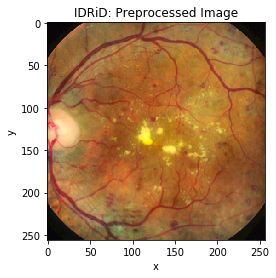

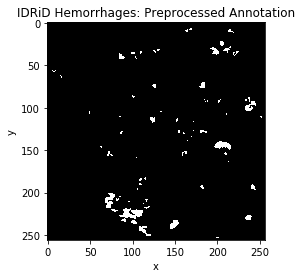

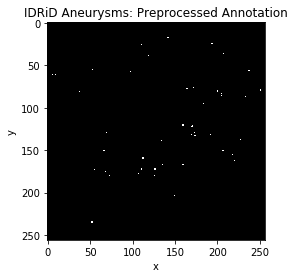

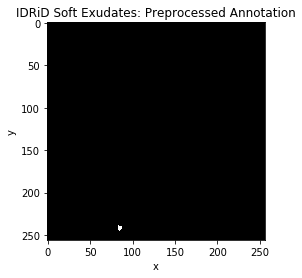

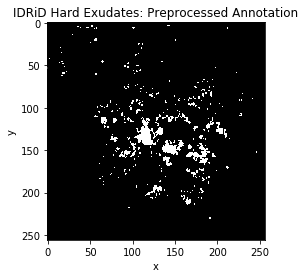

In [22]:
# read in and example image and corresponding annotations
# the resized and preprocessed images are used, but before augmentation and normalization

image = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/Hemorrhages/Arrays/train_images.npy')[2]
annotation_hem = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/Hemorrhages/Arrays/train_annotations.npy')[2]
annotation_aneur = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/Microaneurysms/Arrays/train_annotations.npy')[2]
annotation_softex = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/SoftExudates/Arrays/train_annotations.npy')[0]
annotation_hardex = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/HardExudates/Arrays/train_annotations.npy')[2]


PlotImage(image, database = 'IDRiD', image_name = 'Preprocessed Image', save = True, savepath = save_dir)
PlotImage(annotation_hem, database = 'IDRiD Hemorrhages', image_name = 'Preprocessed Annotation', save = True, savepath = save_dir)
PlotImage(annotation_aneur, database = 'IDRiD Aneurysms', image_name = 'Preprocessed Annotation', save = True, savepath = save_dir)
PlotImage(annotation_softex, database = 'IDRiD Soft Exudates', image_name = 'Preprocessed Annotation', save = True, savepath = save_dir)
PlotImage(annotation_hardex, database = 'IDRiD Hard Exudates', image_name = 'Preprocessed Annotation', save = True, savepath = save_dir)

Number of lesions: 49


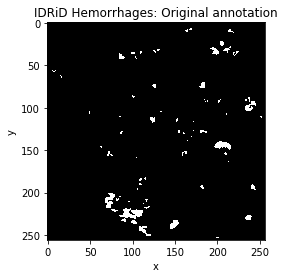

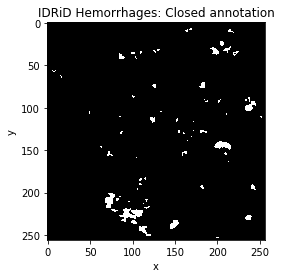

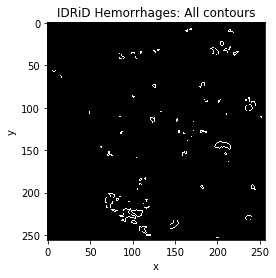

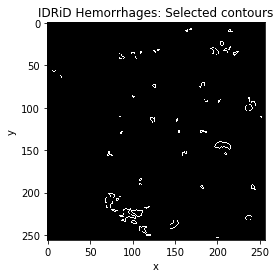

In [25]:
# counting lesions from an annotation file
n_lesions = CountLesions(annotation_hem, KernSizeClosing = kernsize_closing, IteratClosing = closing_iterations, MinLesionArea = minAreaLesion, MaxLesionArea = maxAreaLesion, Show = True)
print('Number of lesions: {}'.format(n_lesions))

C:\Users\lunam\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Number of lesions in the first quadrant: 25
Number of lesions in the second quadrant: 2
Number of lesions in the third quadrant: 0
Number of lesions in the fourth quadrant: 21


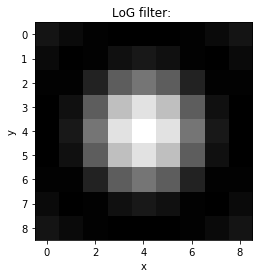

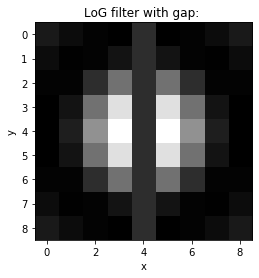

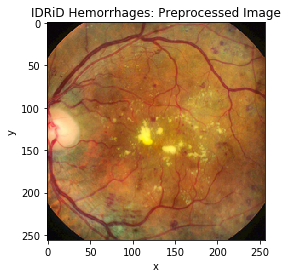

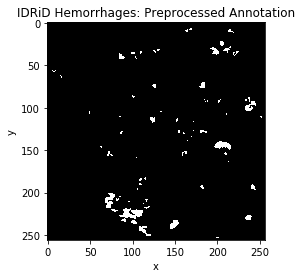

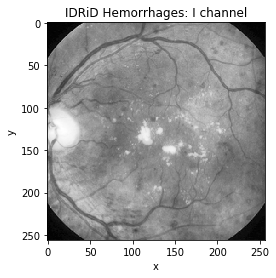

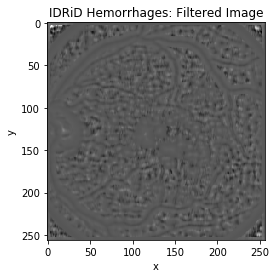

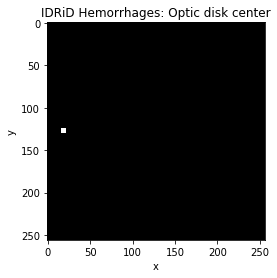

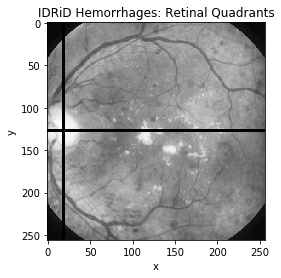

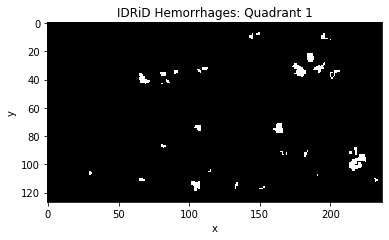

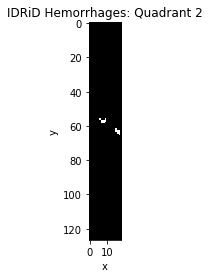

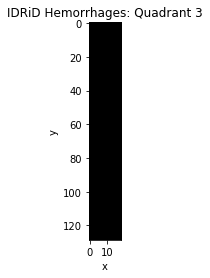

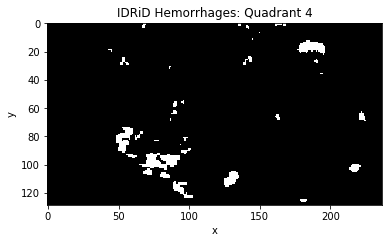

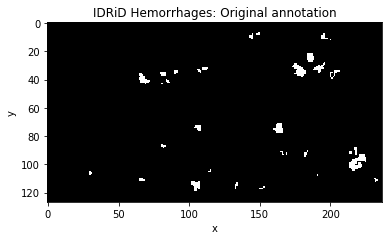

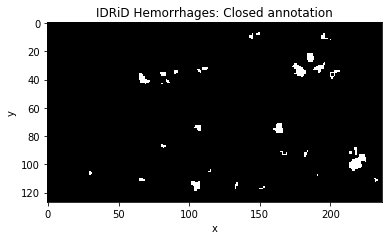

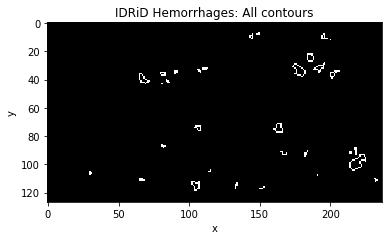

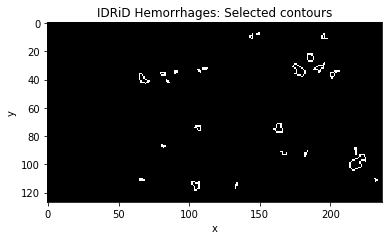

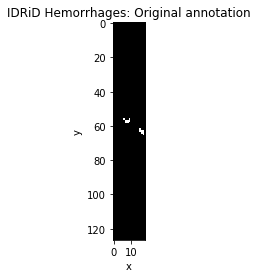

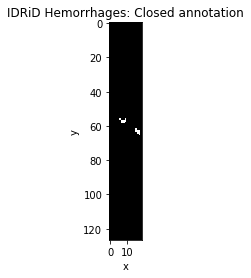

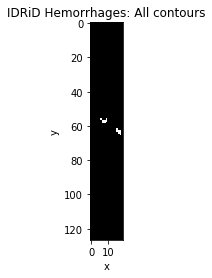

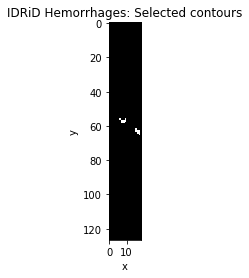

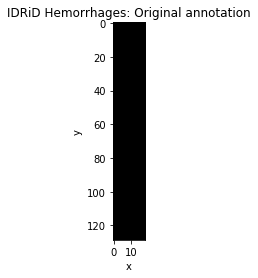

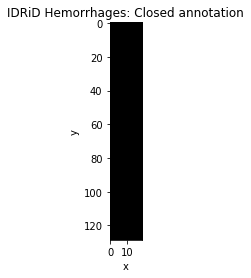

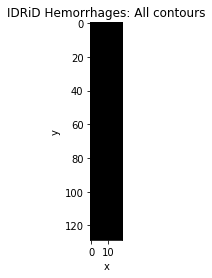

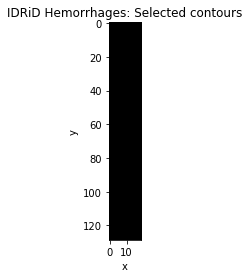

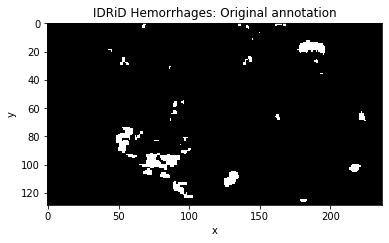

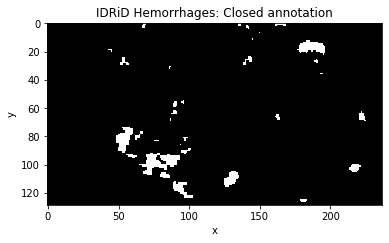

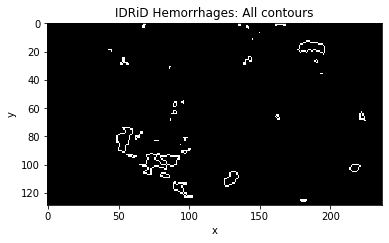

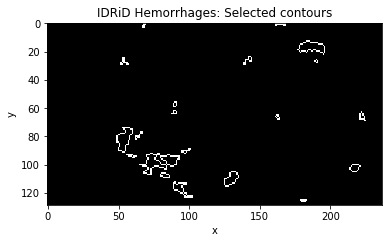

In [24]:
# finding the quadrants and counting lesions per quadrant
n1,n2,n3,n4 = CountLesionsPerQuadrant(image, annotation_hem, FilterSize = OpticDisk_FilterSize, GapSize = OpticDisk_GapSize, ClosingKernSize = kernsize_closing, ClosingItera = closing_iterations, LesionAreaMin = minAreaLesion, LesionAreaMax = maxAreaLesion, Visualize = True)

print('Number of lesions in the first quadrant: {}'.format(n1))
print('Number of lesions in the second quadrant: {}'.format(n2))
print('Number of lesions in the third quadrant: {}'.format(n3))
print('Number of lesions in the fourth quadrant: {}'.format(n4))

In [76]:
# defining the DR grade
DR_grade = DefineDRGrade(image, annotation_hem, annotation_aneur,annotation_hardex, annotation_softex, kernsize_closing, closing_iterations, minAreaLesion, maxAreaLesion, OpticDisk_FilterSize, OpticDisk_GapSize)
print(DR_grade)

True
